In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy

from qiskit import QuantumCircuit, Aer, execute
from qiskit.quantum_info import Operator
from qiskit.extensions import RXGate, RYGate, RZGate

In [10]:
n1 = 5   # cantidad de ciudades
n2 = 10    # cantidad de viajes
n3 = 2    # distancia máxima
a = 0
distance = np.zeros([n1,n1])
moves = np.zeros([n2, 2])

In [11]:
while (np.linalg.matrix_rank(a)!=n1):
    a = np.random.randint(n3, size=(n1,n1))
    np.fill_diagonal(a,0)
    a = np.tril(a) + np.tril(a, -1).T
print("Matriz de rutas: \n{}".format(a))

Matriz de rutas: 
[[0 1 1 1 1]
 [1 0 0 0 0]
 [1 0 0 1 1]
 [1 0 1 0 1]
 [1 0 1 1 0]]


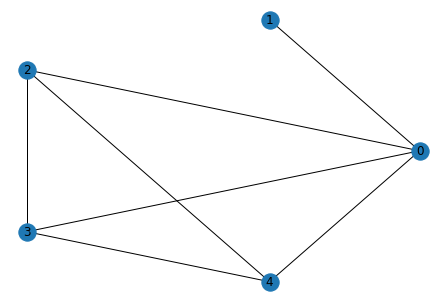

In [12]:
net1 = nx.from_numpy_matrix(copy.deepcopy(a))
#net2 = nx.from_numpy_matrix(copy.deepcopy(a))
#for e in net2.edges():
for e in net1.edges():
    #net2[e[0]][e[1]]['color'] = 'black'
    net1[e[0]][e[1]]['color'] = 'black'

#edge_weights_list = [net2[e[0]][e[1]]['weight'] for e in net2.edges()]
#nx.draw_circular(net2, with_labels=True, width=edge_weights_list)
edge_weights_list = [net1[e[0]][e[1]]['weight'] for e in net1.edges()]
nx.draw_circular(net1, with_labels=True, width=edge_weights_list)

plt.show()

In [13]:
rng = np.random.default_rng()
for i in range(n2):
    moves[i,:] = rng.choice(n1, size=2, replace=False)
print("Matriz de movimientos: \n{}".format(moves))

Matriz de movimientos: 
[[3. 2.]
 [0. 2.]
 [4. 3.]
 [4. 2.]
 [1. 0.]
 [2. 0.]
 [2. 1.]
 [0. 1.]
 [3. 1.]
 [4. 0.]]


In [14]:
caminitos = []
all_edges = [e for e in net1.edges]
for j in range(n2):
    p = nx.dijkstra_path(net1,int(moves[j,0]),int(moves[j,1]))
    cam = []
    for e in range(len(p)-1):
        cam.append(tuple(sorted((p[e], p[e+1]))))    
    caminitos.append(cam)
    print("{:0>3} - Para llegar desde {} hasta {} hay que hacer el siguiente camino: {}".format(j+1, moves[j,0],moves[j,1], p))

001 - Para llegar desde 3.0 hasta 2.0 hay que hacer el siguiente camino: [3, 2]
002 - Para llegar desde 0.0 hasta 2.0 hay que hacer el siguiente camino: [0, 2]
003 - Para llegar desde 4.0 hasta 3.0 hay que hacer el siguiente camino: [4, 3]
004 - Para llegar desde 4.0 hasta 2.0 hay que hacer el siguiente camino: [4, 2]
005 - Para llegar desde 1.0 hasta 0.0 hay que hacer el siguiente camino: [1, 0]
006 - Para llegar desde 2.0 hasta 0.0 hay que hacer el siguiente camino: [2, 0]
007 - Para llegar desde 2.0 hasta 1.0 hay que hacer el siguiente camino: [2, 0, 1]
008 - Para llegar desde 0.0 hasta 1.0 hay que hacer el siguiente camino: [0, 1]
009 - Para llegar desde 3.0 hasta 1.0 hay que hacer el siguiente camino: [3, 0, 1]
010 - Para llegar desde 4.0 hasta 0.0 hay que hacer el siguiente camino: [4, 0]


In [25]:
print("Todas las posibles rutas:",all_edges)
print("Todos las rutas de cada viaje:",caminitos)
print("---")
print("Número total de Rutas: {}".format(len(all_edges)))
for i in range(len(all_edges)):
    for j in range(n2):
        if all_edges[i] in caminitos[j]:
            print("La ruta {} {} la recorre el viaje {} {}".format(i,all_edges[i],j,caminitos[j]))

Todas las posibles rutas: [(0, 1), (0, 2), (0, 3), (0, 4), (2, 3), (2, 4), (3, 4)]
Todos las rutas de cada viaje: [[(2, 3)], [(0, 2)], [(3, 4)], [(2, 4)], [(0, 1)], [(0, 2)], [(0, 2), (0, 1)], [(0, 1)], [(0, 3), (0, 1)], [(0, 4)]]
---
Número total de Rutas: 7
La ruta 0 (0, 1) la recorre el viaje 4 [(0, 1)]
La ruta 0 (0, 1) la recorre el viaje 6 [(0, 2), (0, 1)]
La ruta 0 (0, 1) la recorre el viaje 7 [(0, 1)]
La ruta 0 (0, 1) la recorre el viaje 8 [(0, 3), (0, 1)]
La ruta 1 (0, 2) la recorre el viaje 1 [(0, 2)]
La ruta 1 (0, 2) la recorre el viaje 5 [(0, 2)]
La ruta 1 (0, 2) la recorre el viaje 6 [(0, 2), (0, 1)]
La ruta 2 (0, 3) la recorre el viaje 8 [(0, 3), (0, 1)]
La ruta 3 (0, 4) la recorre el viaje 9 [(0, 4)]
La ruta 4 (2, 3) la recorre el viaje 0 [(2, 3)]
La ruta 5 (2, 4) la recorre el viaje 3 [(2, 4)]
La ruta 6 (3, 4) la recorre el viaje 2 [(3, 4)]


In [23]:
def paquetes_en_ruta(caminos, ruta):
    lista = []
    for i in range(n2):
        if ruta in caminos[i]:
            lista.append(i)
    return lista

def crear_circuito(n):
    I_f = I = np.array([[1, 0],
                  [0, 1]])
    X_f = X = np.array([[0, 1],
                  [1, 0]])    
    for q in range(n-1):
        I_f = np.kron(I_f, I)
        X_f = np.kron(X_f, X)
    J = Operator(1 / np.sqrt(2) * (I_f + 1j * X_f))    
    J_dg = J.adjoint()
    
    if n == 2:        
        dx = np.pi/2
        dy = np.pi/4
        dz = 0
    if n == 4:
        dx = np.pi/2
        dy = 3*np.pi/8
        dz = 3*np.pi/4   

    circ = QuantumCircuit(n,n)
    circ.append(J, range(n))
    for q in range(n):
        circ.append(RXGate(dx),[q])
        circ.append(RYGate(dy),[q])
        circ.append(RZGate(dz),[q])            
    circ.append(J_dg, range(n))
    circ.measure(range(n), range(n))  
    return circ

def juego(lista):
    ganadores = []
    circ = crear_circuito(len(lista))
    backend = Aer.get_backend('qasm_simulator')
    job = execute(circ, backend=backend, shots=1)
    result = job.result()
    measurement = result.get_counts(circ)
    for n,i in enumerate(list(measurement.keys())[0]):
        if i=='1':
            ganadores.append(lista[n])
    return ganadores
    
paquetes_en_ruta = paquetes_en_ruta(caminitos, all_edges[0])
ganadores = juego(paquetes_en_ruta)
print(paquetes_en_ruta)
print(ganadores)

[4, 6, 7, 8]
[4]
